In [1]:
import textattack
import transformers

# Load model, tokenizer, and model_wrapper
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "textattack/bert-base-uncased-SST-2"
)
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "textattack/bert-base-uncased-SST-2"
)
model_wrapper = textattack.models.wrappers.HuggingFaceModelWrapper(model, tokenizer)

# Construct our four components for `Attack`
from textattack.constraints.pre_transformation import (
    RepeatModification,
    StopwordModification,
)
from textattack.constraints.semantics import WordEmbeddingDistance
from textattack.transformations import WordSwapEmbedding
from textattack.search_methods import GreedyWordSwapWIR

goal_function = textattack.goal_functions.UntargetedClassification(model_wrapper)
constraints = [
    RepeatModification(),
    StopwordModification(),
    WordEmbeddingDistance(min_cos_sim=0.9),
]
transformation = WordSwapEmbedding(max_candidates=50)
# weighted-saliency
search_method = GreedyWordSwapWIR(wir_method="weighted-saliency")

# Construct the actual attack
attack = textattack.Attack(goal_function, constraints, transformation, search_method)
attack.cuda_()

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

C:\Users\Isaac\AppData\Roaming\Python\Python38\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Isaac\.cache\huggingface\hub\models--textattack--bert-base-uncased-SST-2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


In [2]:
import pandas as pd

results = pd.read_csv("ag-news_pwws_bert.csv")
#results.columns

In [25]:

"""successful_perturbed_texts = results.loc[results["result_type"] == "Successful", "perturbed_text"].tolist()
failed_perturbed_texts = results.loc[results["result_type"] == "Failed", "perturbed_text"].tolist()

failed_perturbed_outputs = results.loc[results["result_type"] == "Failed", "perturbed_output"].tolist()
successful_perturbed_outputs = results.loc[results["result_type"] == "Successful", "original_output"].tolist()"""


original_texts = results["original_text"].tolist()
perturbed_texts =results["adversarial_text"].tolist() 

original_outputs = results["original_class"].tolist()
perturbed_outputs =results["adversarial_class"].tolist() 

In [4]:
import re
import string
# Clean Text
def remove_brackets(text):
    text = text.replace('[[', '')
    text = text.replace(']]', '')
    return text

perturbed_texts = [remove_brackets(text) for text in perturbed_texts]
original_texts = [remove_brackets(text) for text in original_texts]

def clean_text(text):
    pattern = "[" + re.escape(string.punctuation) + "]"
    cleaned_text = re.sub(pattern, " ", text)

    return cleaned_text

perturbed_texts = [clean_text(text) for text in perturbed_texts]
original_texts = [clean_text(text) for text in original_texts]



In [5]:
perturbed_texts = [text.lower() for text in perturbed_texts]
original_texts = [text.lower() for text in original_texts]

In [6]:
from FlowCorrector import Flow_Corrector

corrector = Flow_Corrector(
    attack,
    word_rank_file="en_full_ranked.json",
    word_freq_file="en_full_freq.json",
)


In [7]:
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm_notebook

victim_model = attack.goal_function.model

original_classes = [
    torch.argmax(F.softmax(victim_model(original_text), dim=1)).item()
    for original_text in tqdm_notebook(original_texts)
]


  0%|          | 0/424 [00:00<?, ?it/s]

In [18]:
""" 0 :World
    1 : Sports
    2 : Business
    3 : Sci/Tech"""

corrected_classes = corrector.correct(perturbed_texts)

  0%|          | 0/424 [00:00<?, ?it/s]

c:\Users\Isaac\anaconda3\envs\textattackenv\lib\site-packages\torch\nn\modules\module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [19]:
def count_matching_classes(original, corrected, perturbed_texts=None):
    if len(original) != len(corrected):
        raise ValueError("Arrays must have the same length")
    hard_samples = []
    easy_samples = []

    matching_count = 0

    for i in range(len(corrected)):
        if original[i] == corrected[i]:
            matching_count += 1
            easy_samples.append(perturbed_texts[i])
        elif perturbed_texts != None:
            hard_samples.append(perturbed_texts[i])

    return matching_count, hard_samples, easy_samples


match_, hard_samples, easy_samples = count_matching_classes(
    original_classes, corrected_classes, perturbed_texts
)

In [23]:
match_/424

0.6014150943396226

In [ ]:
with open("detected_samples_ag_news.txt", "w") as f:
    for sample in easy_samples:
        f.write(sample + "\n")

In [ ]:
index_order = wir_gradient(attack, goal_function.model, detected_text)

# The prblm is tht it exists many rare words with freq from 1 to 10

# freq_thershold = len(word_ranked_frequence) * 0.01

# for now i sugest to take the words taht have freq > freq_thershold (200 in paper)

freq_thershold = 2000

index_order_1 = [
    idx
    for idx in index_order

    if detected_text.words[idx] in word_frequence.keys()

    and word_frequence[detected_text.words[idx]] < freq_thershold

]

print(

    f"from {len(index_order)} ranked word it remain only {len(index_order_1)} within frequency theshold = {freq_thershold} "

)

# or we take the lowest 30% in the important ranked words ?
index_order = index_order[:int(len(index_order) * 0.3)]
index_order_ = {
    idx : word_ranked_frequence[detected_text.words[idx]]
    for idx in index_order
    if detected_text.words[idx] in word_ranked_frequence.keys()
}

index_order_ = sorted(index_order_.items(), key=lambda item: item[1], reverse=False)
lowest = 0.15
index_order_ = [idx[0]for idx in index_order_][:int(len(index_order) * lowest)]

print(f"from {len(index_order)} ranked word {len(index_order_)} word represent {lowest * 100}% with the lowest frequency")

In [ ]:
def remove_brackets(text):
    text = text.replace('[[', '')
    text = text.replace(']]', '')
    return text

text = "Fears for T [[percent]] pension after [[debate]] [[Syndicates]] [[portrayal]] [[worker]] at Turner   Newall say they are 'disappointed' after [[chatter]] with [[bereaved]] [[parenting]] [[corporations]] [[Canada]] Mogul." 
print(remove_brackets(text))


In [ ]:
import json

with open('en_full.txt', 'r') as f:
    lines = f.readlines()


freq_dict = {line.split()[0]: int(line.split()[1]) for line in lines}


sorted_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True))


ranked_dict = {word: freq for word, freq in sorted_dict.items() }


with open('en_full_freq.json', 'w') as f:
    json.dump(ranked_dict, f)

print("The word frequencies have been successfully ranked and saved to ranked_freq.json file.")


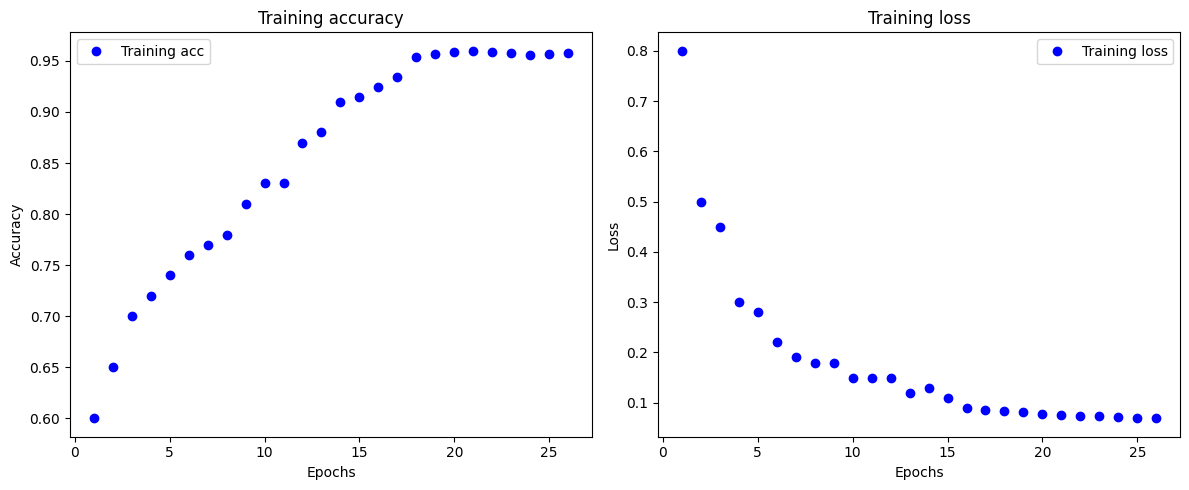

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming these are your accuracy and loss values
accuracy = [0.6, 0.65, 0.7, 0.72, 0.74, 0.76, 0.77, 0.78, 0.81, 0.83, 0.83, 0.87,0.88, 0.91, 0.915, 0.924, 0.934, 0.954, 0.957, 0.959, 0.96, 0.959, 0.958, 0.956, 0.957, 0.958]
loss = [0.8, 0.5, 0.45, 0.30, 0.28, 0.22, 0.19, 0.18, 0.18, 0.15, 0.15, 0.15,  0.12, 0.13, 0.11, 0.09, 0.086, 0.083, 0.082, 0.077, 0.076, 0.074, 0.073, 0.072, 0.070, 0.069]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

plt.savefig("accuracy loss.pdf")
